In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.io import wavfile
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

2748588032/2748572632 [==============================] - 47s 0us/step


,file_name,normalized_transcription
0,LJ017-0067,"Palmer was ably defended, but the weight of ev..."
1,LJ011-0192,The fact of the abduction did not transpire fo...
2,LJ026-0162,In non-green plants like the Indian pipe and m...


# __Sampling and quantization__
- __Sampling rate__: the number of samples taken per second

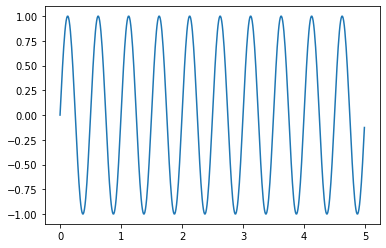

In [3]:
import numpy as np
from matplotlib import pyplot as plt

# example of sampling rate
sampling_rate = 100  # in hertz
time = 5  # in seconds
frequency = 2

x = np.linspace(0, time, sampling_rate * time, endpoint=False)
frequencies = x * frequency
# 2pi because np.sin takes radians
y = np.sin((2 * np.pi) * frequencies)

# Generate a 2 hertz sine wave that lasts for 5 seconds
plt.plot(x, y)
plt.show()

Sampling rate:  22050
Time of the audio:  3.815192743764172


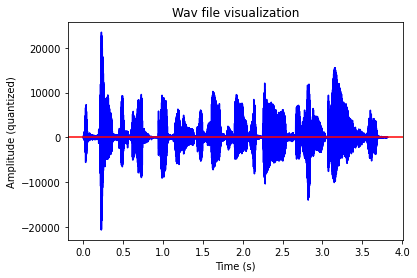

In [4]:
wav_filepath = os.path.join(wavs_path, metadata_df.iloc[1]["file_name"] + ".wav")
sampling_rate, data = wavfile.read(wav_filepath) # read wav file with scipy.io.wavfile
print("Sampling rate: ", sampling_rate) # this sampling rate is taken from the header of wav file
time = np.linspace(0, data.shape[0] / sampling_rate, num=data.shape[0]) 
print("Time of the audio: ", data.shape[0] / sampling_rate) 

plt.plot(time, data, color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (quantized)")
plt.title("Wav file visualization")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

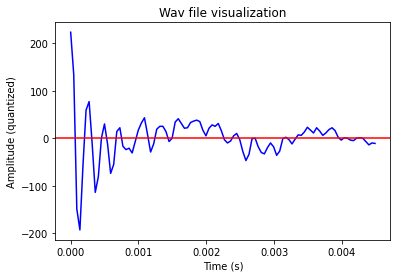

In [5]:
plt.plot(time[:100], data[:100], color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (quantized)")
plt.title("Wav file visualization")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# __Windowing__

In [6]:
n_data_points = data.shape[0]
window_size = 25 * (10 ** -3)
offset = 10 * (10 ** -3)
window_length = int(round(window_size * sampling_rate))
window_step = int(round(offset * sampling_rate))
n_windows = int(np.ceil(float(abs(n_data_points - window_length) / window_step)))
print("window length: ", window_length)
print("window step: ", window_step)
print("number of windows: ", n_windows)

window length:  551
window step:  220
number of windows:  380


In [7]:
pad_data_length = n_windows * window_step + window_length
z = np.zeros((pad_data_length - n_data_points))
pad_data = np.append(data, z)

In [8]:
print(data.shape)
print(pad_data.shape)

(84125,)
(84151,)


In [9]:
sub_indice_1 = np.tile(np.arange(0, window_length), (n_windows, 1))
print(sub_indice_1)

[[  0   1   2 ... 548 549 550]
 [  0   1   2 ... 548 549 550]
 [  0   1   2 ... 548 549 550]
 ...
 [  0   1   2 ... 548 549 550]
 [  0   1   2 ... 548 549 550]
 [  0   1   2 ... 548 549 550]]


In [10]:
sub_indice_2 = np.tile(np.arange(0, n_windows * window_step, window_step), (window_length, 1)).T
print(sub_indice_2)

[[    0     0     0 ...     0     0     0]
 [  220   220   220 ...   220   220   220]
 [  440   440   440 ...   440   440   440]
 ...
 [82940 82940 82940 ... 82940 82940 82940]
 [83160 83160 83160 ... 83160 83160 83160]
 [83380 83380 83380 ... 83380 83380 83380]]


In [12]:
indices = sub_indice_1 + sub_indice_2
indices = indices.astype(np.int16)

In [13]:
print(indices.shape)

(380, 551)


In [14]:
windows = data[indices]

In [15]:
print(windows.shape)

(380, 551)


In [16]:
hanning_windows = windows * np.hanning(window_length)

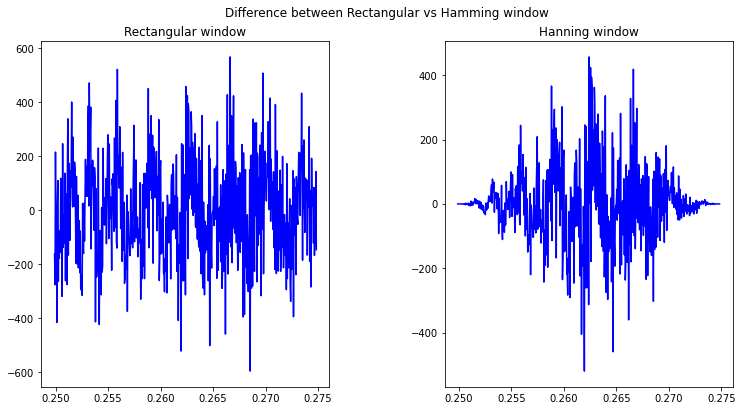

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Difference between Rectangular vs Hamming window')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
ax1.plot(time[window_length * 10:window_length * 10 + window_length], windows[10], color="blue")
ax1.title.set_text("Rectangular window")
ax2.plot(time[window_length * 10:window_length * 10 + window_length], hanning_windows[10], color="blue")
ax2.title.set_text("Hanning window")
plt.show()

# __Fast Fourier Transform__

In [18]:
NFFT = 512 # number of frequency bands
mag_frames = np.absolute(np.fft.rfft(hanning_windows, NFFT))  # Magnitude of the FFT
k = np.fft.rfftfreq(NFFT)
freq = k / sampling_rate
pow_frames = (mag_frames) ** 2 * 1.0 / NFFT # Power Spectrum

In [19]:
print("magnitude windows from fast fourier transform: ", mag_frames.shape)

magnitude windows from fast fourier transform:  (380, 257)


# __Mel Filter Bank__

In [20]:
n_filters = 40 # triangular filter
low_freq_mel = 0
# f = sampling_rate / 2 (nyquist theorem)
high_freq_mel = (1127 * np.log(1 + (sampling_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # Equally spaced in Mel scale
hz_points = (700 * (np.exp(mel_points / 1127) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sampling_rate)
fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))  
for m in range(1, n_filters + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    # print(f_m_minus)
    # print(f_m)
    # print(f_m_plus)

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

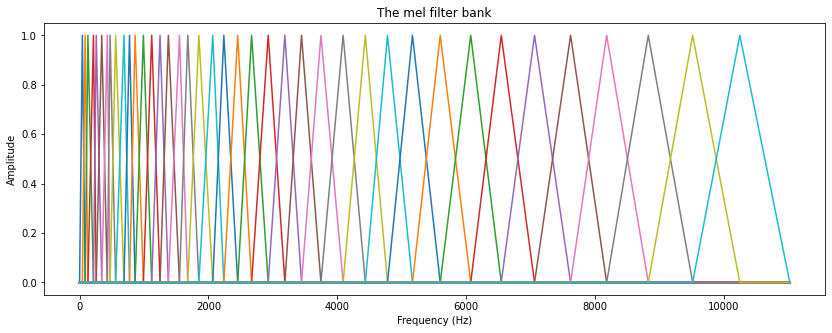

In [21]:
times = np.linspace(0, sampling_rate / 2, num=fbank.shape[1])
plt.figure(figsize=(14, 5))
plt.plot(times, fbank.T)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("The mel filter bank")
plt.show()

# __The Spectrogram__

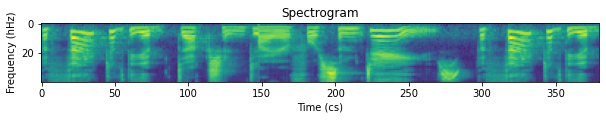

In [95]:
plt.figure(figsize=(10, 5))
spectrogram = filter_banks
mean = np.mean(spectrogram)
std = np.mean(spectrogram)
spectrogram = (spectrogram - mean) / std
spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
plt.imshow(spectrogram)
plt.xlabel("Time (cs)")
plt.ylabel("Frequency (hHz)")
plt.title("Spectrogram")
plt.show()

In [22]:
print(filter_banks.shape)

(380, 40)


In [50]:
print(np.reshape(filter_banks, (-1, filter_banks.shape[0], 1)).shape)

(380, 40, 1)


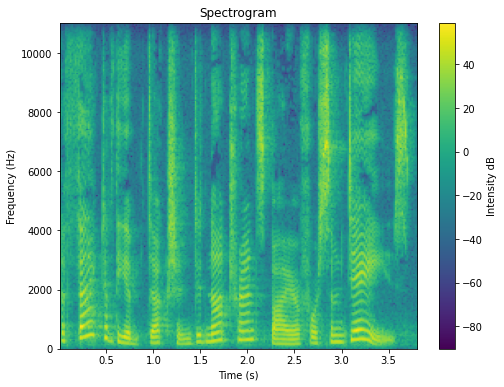

In [93]:
plt.figure(2, figsize=(8,6))
Pxx, freqs, bins, im = plt.specgram(data, Fs=sampling_rate, NFFT=NFFT)
cbar=plt.colorbar(im)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title("Spectrogram")
cbar.set_label('Intensity dB')
plt.show()